## Callback API demo

In this demo we are going to use the callback API to **track some useful information while training** a SLIM miner

We simply define custom python functions, and submit them to create an instance of `skmine.callbacks.CallBacks`.

In [6]:
import skmine

print("This tutorial was tested with the following version of skmine :", skmine.__version__)

This tutorial was tested with the following version of skmine : 0.0.9


In [3]:
import pandas as pd
import numpy as np

from skmine.callbacks import CallBacks
from skmine.itemsets import SLIM
from skmine.datasets.fimi import fetch_mushroom

In [2]:
mushroom = fetch_mushroom()
mushroom.head()

0    [1, 3, 9, 13, 23, 25, 34, 36, 38, 40, 52, 54, ...
1    [2, 3, 9, 14, 23, 26, 34, 36, 39, 40, 52, 55, ...
2    [2, 4, 9, 15, 23, 27, 34, 36, 39, 41, 52, 55, ...
3    [1, 3, 10, 15, 23, 25, 34, 36, 38, 41, 52, 54,...
4    [2, 3, 9, 16, 24, 28, 34, 37, 39, 40, 53, 54, ...
Name: mushroom, dtype: object

In [3]:
# set max_time to a limit value so that the dataset compression is not too long
slim = SLIM(max_time=30)

-------------------

### Define your own callbacks

We define custom functions, that will take the result of the function they target as input. Those results will be ingested for later reuse

Here we define two methods:

1. `post_evaluate` is executed after `SLIM.evaluate`. It tracks sizes for both the data and the model
2. `post_gen` is executed after `SLIM.generate_candidates`, and just records the size of the current batch of candidates

In [4]:
sizes = list()
candidate_sizes = list()

def post_evaluate(data_size, model_size, *args):
    sizes.append((data_size, model_size))

def post_gen(candidates):
    candidate_sizes.append(len(candidates))

A `skmine.callbacks.CallBacks` is a collection of callbacks.

It's a mapping between function names and their dedicated callbacks. When an instance of `skmine.callbacks.CallBacks` is called (`() operator`) on an object, it looks for internal methods and tries to attach the callbacks.

In [5]:
callbacks = CallBacks(evaluate=post_evaluate, generate_candidates=post_gen)

callbacks(slim)

In [6]:
%time slim.fit(mushroom).discover()

CPU times: user 30.1 s, sys: 112 ms, total: 30.2 s
Wall time: 30.1 s


,itemset,usage
0,"[2, 23, 28, 34, 36, 39, 53, 56, 59, 63, 85, 86...",864
1,"[2, 23, 28, 34, 36, 39, 53, 56, 59, 63, 85, 86...",864
2,"[1, 24, 29, 34, 36, 39, 52, 56, 61, 66, 85, 86...",648
3,"[1, 24, 29, 34, 36, 39, 52, 56, 61, 66, 85, 86...",648
4,"[1, 24, 34, 36, 38, 48, 53, 58, 59, 63, 85, 86...",432
...,...,...
157,[22],16
158,[75],8
159,[89],8
160,[8],4


### Inner view of MDL learning 

The plot below clearly shows **how SLIM performs compression**.

While the blue curve represents the size of the data, 
red vertical lines emphasize the end of a batch of candidates.

**We can clearly dinstinguish the beginning of a batch of candidates, where the learning curve is quite abrupt, from the end of a batch, where it reaches a plateau**.

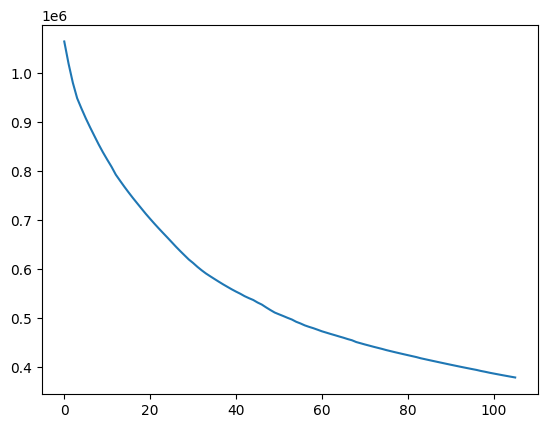

In [7]:
df = pd.DataFrame(sizes, columns=['data_size', 'model_size'])
ax = df.data_size.plot()

------------------
Here is how the model size goes up

<AxesSubplot: >

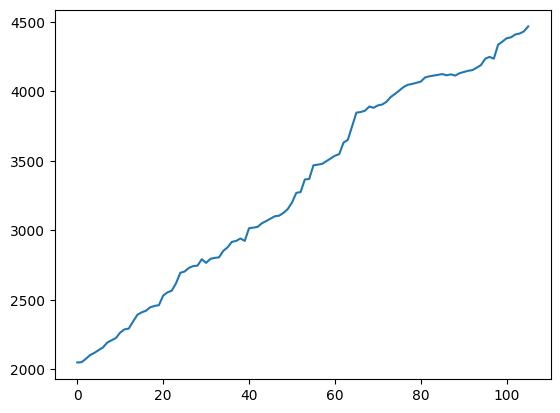

In [8]:
df.model_size.plot()

And finally the evolution of the total size of our dataset after compression via SLIM following MDL

<AxesSubplot: >

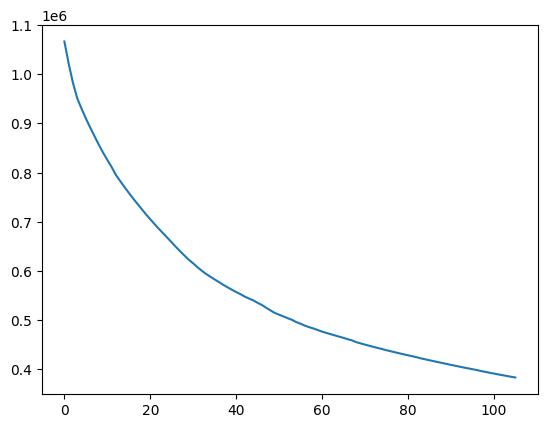

In [9]:
df['total_size'] = df['model_size']+df['data_size']
df.total_size.plot()

From the sizes saved in df, we can determine the compression ratio of our dataset after applying SLIM

In [10]:
compression_percentage = df['total_size'].iloc[-1]/df['total_size'].iloc[0]*100
compression_percentage

35.97993591669107